# Test changes for every commit

In [1]:
from lightkurve import KeplerTargetPixelFile as ktpf
from lightkurve import KeplerLightCurveFile
# tpf = ktpf.from_archive('211416749', campaign = 5, cadence='long')
# lc = tpf.to_lightcurve().normalize().remove_nans().remove_outliers().correct(windows=10).remove_outliers()
# tpf = ktpf.from_archive('Kepler-10', quarter=3, cadence='long')
# lc = tpf.to_lightcurve().normalize().remove_outliers().flatten().remove_outliers().fill_gaps()
target = "KIC11615890"
lc = KeplerLightCurveFile.from_archive(target, quarter=0).PDCSAP_FLUX.normalize()
for q in range(1, 17):
    lc = lc.append(KeplerLightCurveFile.from_archive(target, quarter=q).PDCSAP_FLUX.normalize())

In [2]:
lc = lc.remove_nans()

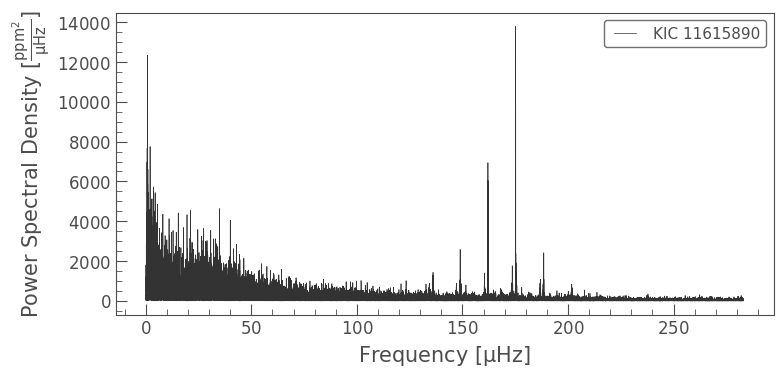

In [25]:
from astropy import units as u
import numpy as np
pg = lc.periodogram(freq_unit = u.microhertz)
pg.plot()

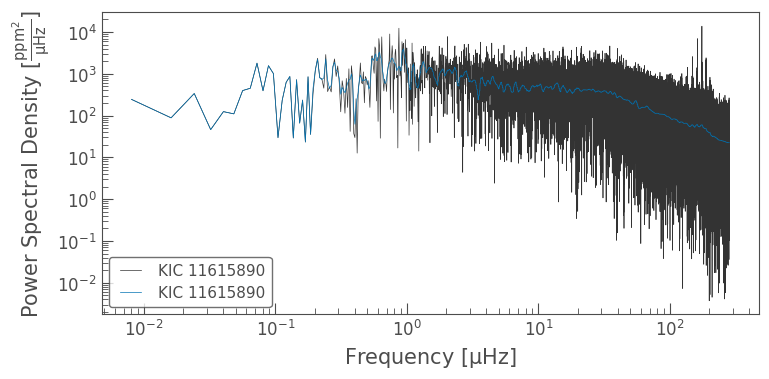

In [26]:
ax = pg.plot(scale='log')
snr, bkg = pg.estimate_snr(return_trend=True)
bkg.plot(ax=ax,scale='log')

In [27]:
snr

SNRPeriodogram(ID: 11615890)

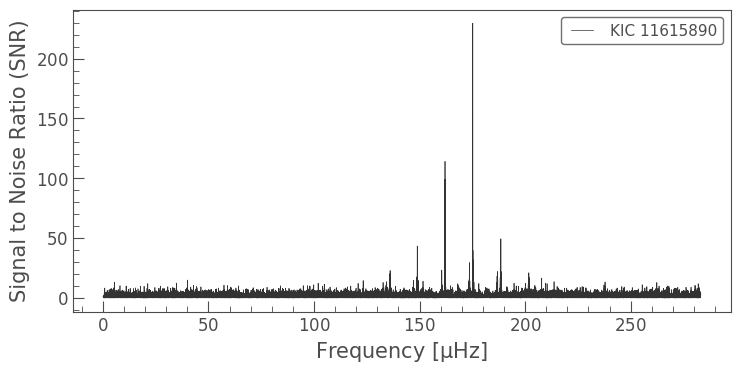

In [28]:
snr.plot()

In [42]:
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
#TODO: Check to see if periodogram object is already an snr periodogram
snr = pg.estimate_snr()
#TODO: Justify this kernel
smoothed_snr = gaussian_filter(snr.power.value, 1000)

numax = snr.frequency[np.argmax(smoothed_snr)]
print(numax)

173.97097506870205 uHz


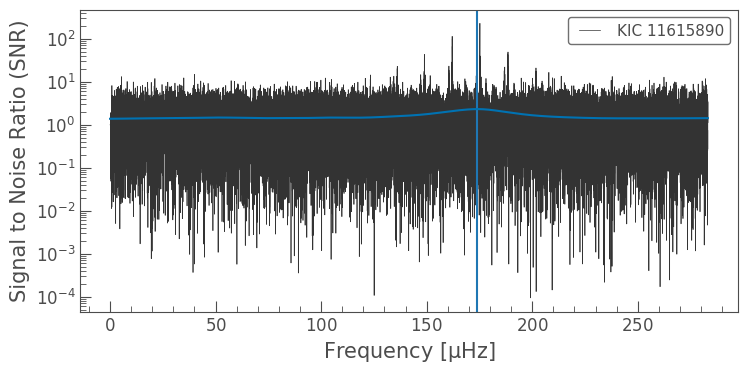

In [43]:
ax = snr.plot()
ax.axvline(numax.value)
ax.set_yscale('log')
ax.plot(snr.frequency, smoothed_snr)

In [44]:
def _autocorrelate(frequency, power, numax):
    fs = np.median(np.diff(frequency))
    fwhm = int(np.floor(1.0 * 0.66 * numax.value**0.88 / fs.value))
    fwhm -= fwhm % 2                                    # Make the FWHM value even (%2 = 0 if even, 1 if odd)
    x = int(numax / fs)                                 #Find the index value of numax
    s = np.hanning(len(power[x-fwhm:x+fwhm]))      #Define the hanning window for the evaluated frequency space
    C = power[x-fwhm:x+fwhm] * s                   #Multiply the evaluated SNR space by the hanning window
    result = np.correlate(C, C, mode='full')            #Correlated the resulting SNR space with itself

    return result[int(len(result)/2):], C    
def dnu_mass_prior(numax, numax_sol=3050.0,
               dnu_sol=135.1, teff_sol=5777.0):
    ''' Mass scaling relation ...
    M/M' = (numax/numax')**3 (dnu/dnu')**-4 (teff/teff')**(3/2)
    So dnur**4 = numaxr**3 teffr**3/2 * Mr**-1*
    dnur = (nuamxr**3 * teffr**3/2 / Mr)**1/4
    dnu = (nuamxr**3 * teffr**3/2 / Mr)**1/4 * dnu'
    '''
    numaxr = numax / numax_sol
    teffr = np.array([3500, 5500]) / teff_sol
    Mr = np.array([10.0, 0.1])
    dnu = (numaxr**3 * teffr**1.5 / Mr)**0.25 * dnu_sol
    return dnu

In [47]:
estimate_radius()

NameError: name 'estimate_radius' is not defined

In [45]:
'''<DNu estimation>'''
#Calculate the ACF for the best numax estimate
acf, _ = _autocorrelate(snr.frequency, snr.power, numax)
#Finding Mass-prior limits on dnu values for the best numax esimate
lower, upper = dnu_mass_prior(numax.value)

fs = np.median(np.diff(snr.frequency))
#Calculating the correpsonding indices
l = int(np.floor(lower / fs.value))
u = int(np.floor(upper / fs.value))

#Building list of possible dnus
dnus = np.arange(len(acf)) * fs
acfrange = acf[l:u]     #The acf range to look for dnu
dnurange = dnus[l:u]    #The range of dnus to look for dnu

#The best dnu value is at the position of maximum acf power within the range
dnu = dnurange[np.argmax(acfrange)]
print(dnu)

13.116667517677271 uHz


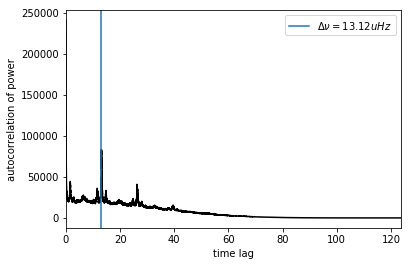

In [46]:
lags = fs.value*np.arange(len(acf))

plt.plot(lags, acf, "k")
plt.xlim(lags[0], lags[-1])
plt.axvline(dnu.value, label="$\Delta \\nu = {0:.2f}\,$".format(dnu))
plt.xlabel("time lag")
plt.ylabel("autocorrelation of power")
plt.legend();